# setting

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [3]:

# 데이터 시각화에 사용할 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn import tree
import graphviz


from collections import Counter

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

import xgboost as xgb

# 평가 지표
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


In [4]:
import easydict
args = easydict.EasyDict()

# path 정보
args.default_path = '/content/data/MyDrive/ai_study/1. Machine Learning/data/240826contest/'
args.train_csv = args.default_path+'train.csv'
args.test_csv = args.default_path+'test.csv'
args.default_submission_csv = args.default_path+'submission.csv'

args.submission_csv = args.default_path+'result/submission_0220.csv'
args.save_results = args.default_path+"result/model_results.json"

# 데이터 분석을 위한 변수들
args.random_state = 21
args.results = []

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.ion()

import warnings
warnings.filterwarnings('ignore')

# data preprocessing

## load data

In [ ]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_train.shape, ori_test.shape

((916, 12), (393, 11))

In [ ]:
ori_train.drop('passengerid', axis=1, inplace=True)

In [ ]:
ori_test.set_index(['passengerid'], inplace=True)

In [ ]:
y = ori_train['survived']
X = ori_train.drop(['survived'], axis=1)

y_ori_train = ori_train['survived']
x_ori_train = ori_train.drop(['survived'], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=ori_train['survived'], random_state=args.random_state)

## EDA

### age

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

eda_df = pd.read_csv(args.default_path+'train.csv')

> 추측 : 나이별 생존율이 다를 것이다.

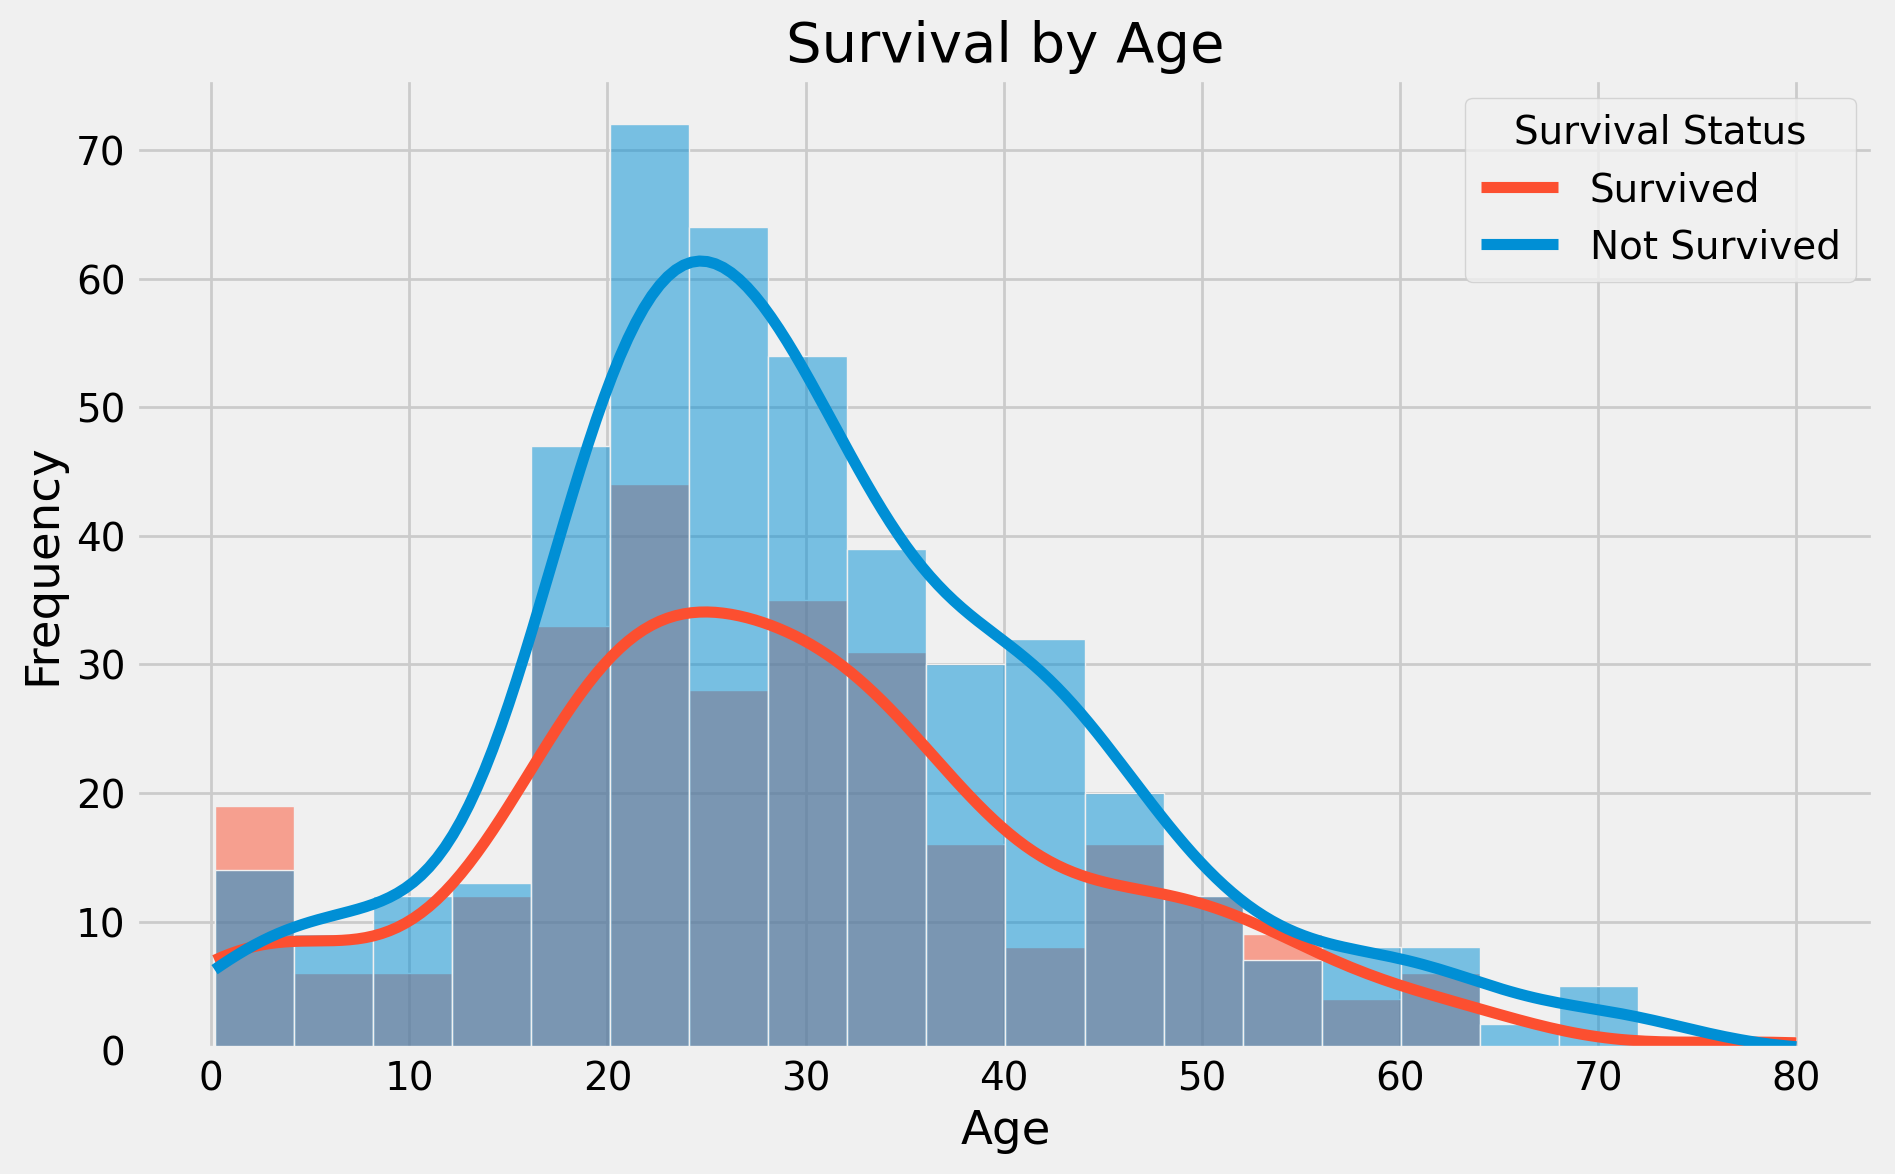

In [36]:
# Extracting the age column
age_data = eda_df["age"]
survived_data = eda_df["survived"]

# Histogram of survival by age
plt.figure(figsize=(10, 6))
sns.histplot(data=eda_df, x='age', hue='survived', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Survival by Age')
plt.legend(title='Survival Status', labels=['Survived', 'Not Survived'])
plt.show()


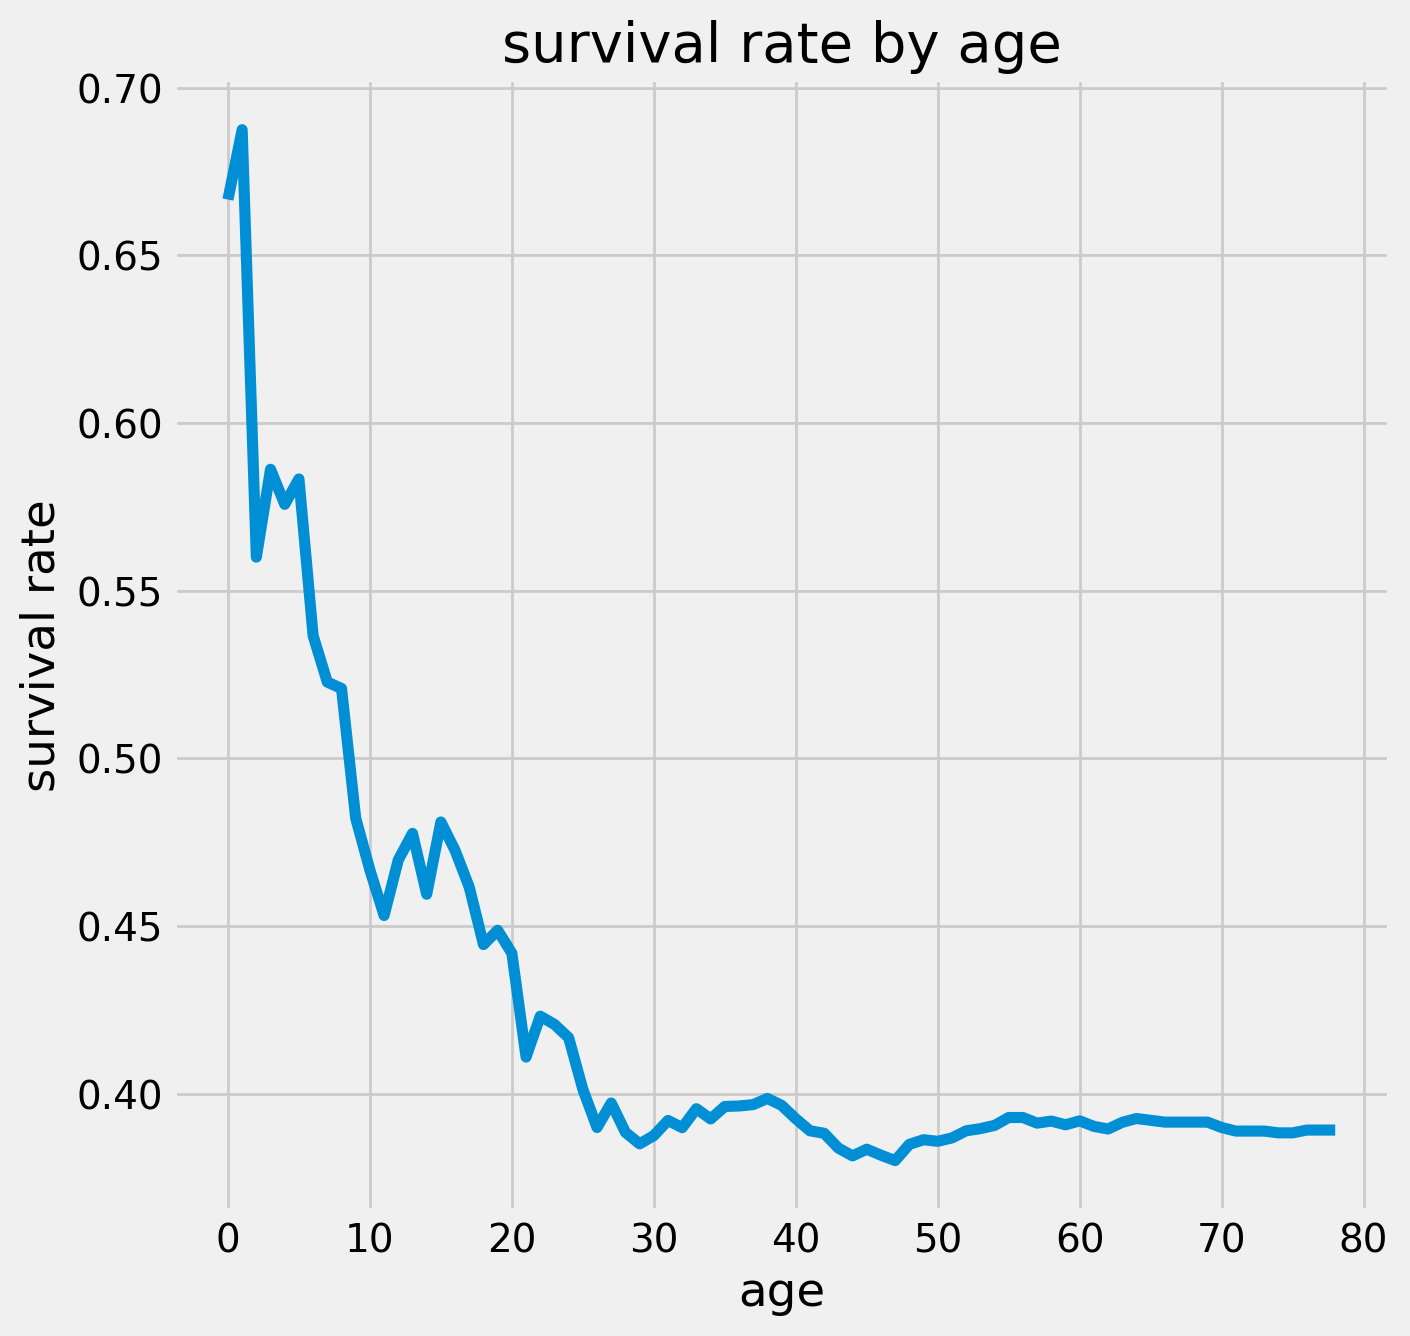

In [38]:
# 생존율을 입력받을 List 생성
age_range_survival_ratio = []

# 1살 부터 생존율 구하기
for i in range(1,80):
    age_range_survival_ratio.append(eda_df[eda_df['age'] < i]['survived'].sum() / len(eda_df[eda_df['age'] < i]['survived']))

plt.figure(figsize=(7,7))
plt.plot(age_range_survival_ratio)
plt.title('survival rate by age')
plt.ylabel('survival rate')
plt.xlabel('age')

plt.show()

- 20세 이하의 생존율이 높다.
- child 항목을 새로 만들어서 모델의 학습율을 높힘

### sibsp와 parch

- sibsp : 타이타닉 호에 동승한 자매/배우자의 수
- parch : 타이타닉 호에 동승한 부모/자식의 수

> 추측 : sibsp와 parch를 더하면 같이 동승한 가족의 수가 나올 것이고, 유의미한 값이 나올 것이다.



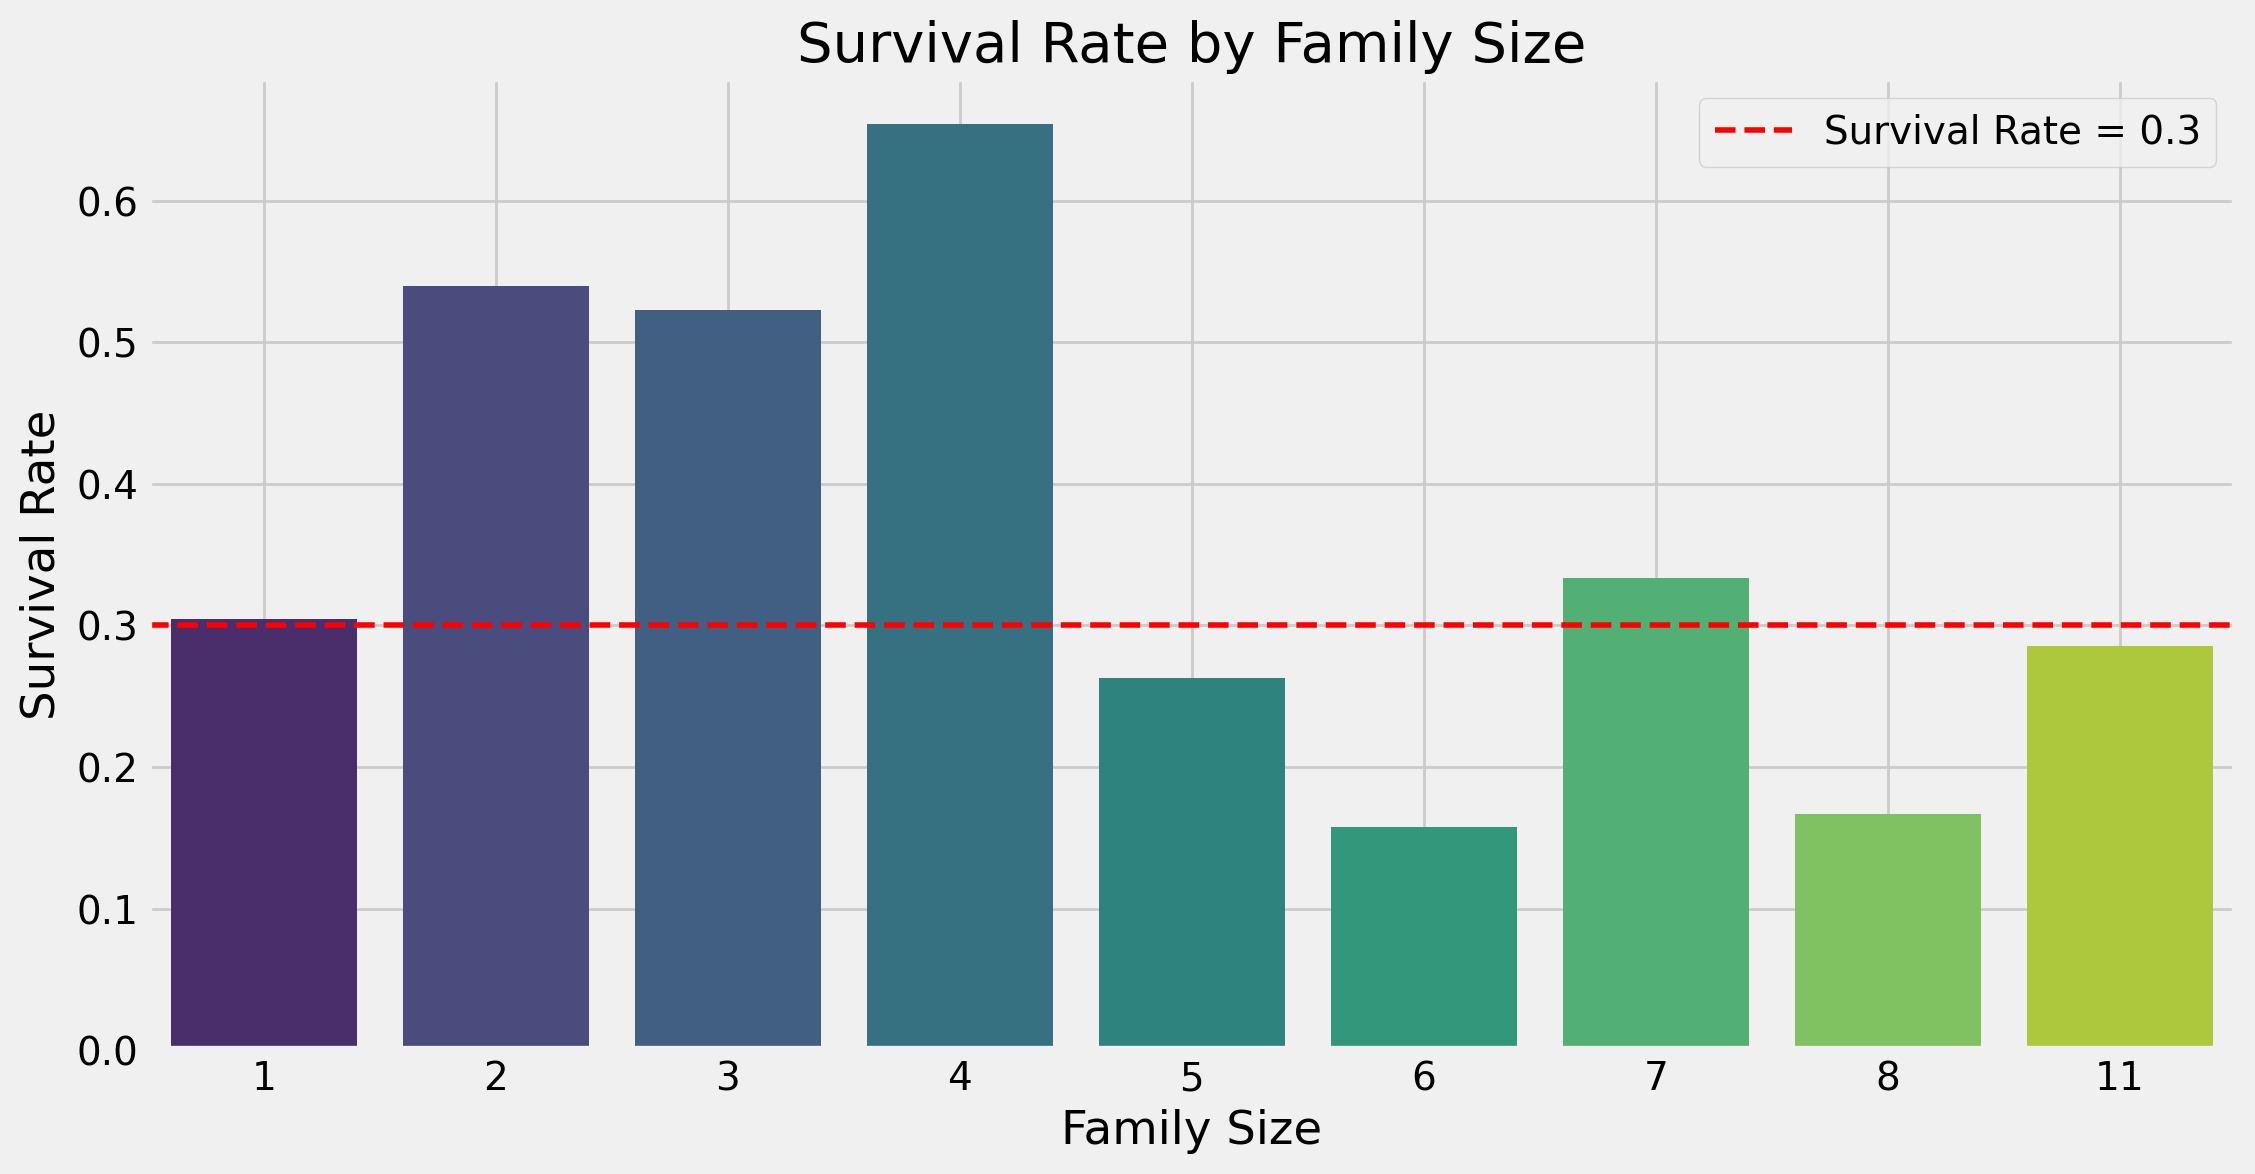

In [33]:
eda_df['family_size'] = eda_df['sibsp'] + eda_df['parch'] + 1

# family_size에 따른 생존율 계산
family_size_survival_rate = eda_df.groupby('family_size')['survived'].mean().reset_index()

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.barplot(x='family_size', y='survived', data=family_size_survival_rate, palette='viridis')
plt.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Survival Rate = 0.3')
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.legend()
plt.grid(True)
plt.show()

- family size가 2~4인 가족은, 다른 가족에 비해 생존율이 높다
- -> 새로운 항목 2~4-family 생성



## data preprocessing

In [ ]:
data_list = [x_train, x_test, ori_test,x_ori_train]

# 중앙값 및 최빈값 계산
age_median = x_train['age'].median()
fare_median = x_train['fare'].median()
embarked_mode = x_train['embarked'].mode().values[0]

# 삭제할 열 및 변경할 열 정의
drop_cols = ['name', 'ticket', 'cabin']
change_cols = ['2~4-family']
drop_cols_for_family_size = ['sibsp', 'parch', 'familysize']

# 데이터 전처리 및 인코딩
encoded_data_list = []
enc = OneHotEncoder()


for data in data_list:
    # 열 삭제
    data.drop(drop_cols, axis=1, inplace=True)

    # 결측값 채우기
    data['age'].fillna(age_median, inplace=True)
    data['fare'].fillna(fare_median, inplace=True)
    data['embarked'].fillna(embarked_mode, inplace=True)

    # 새로운 열 추가
    data['child'] = (data['age'] < 17).astype(int)
    data['familysize'] = data['sibsp'] + data['parch'] + 1
    data['2~4-family'] = ((2 <= data['familysize']) & (data['familysize'] <= 4)).astype(int)
    data.drop(drop_cols_for_family_size, axis=1, inplace=True)

    # 인코딩할 열과 일반 열 분리
    enc_cols = ['gender', 'embarked']
    normal_cols = list(set(data.columns) - set(enc_cols))

    # OneHotEncoder를 사용하여 인코딩
    tmp_data = pd.DataFrame(
        enc.fit_transform(data[enc_cols]).toarray(),
        columns=enc.get_feature_names_out()
    )
    enc_data = pd.concat(
        [data[normal_cols].reset_index(drop=True), tmp_data.reset_index(drop=True)],
        axis=1
    )
    encoded_data_list.append(enc_data)

# 인코딩된 데이터를 원래 변수에 할당
x_train, x_test, ori_test,x_ori_train = encoded_data_list
data_list = encoded_data_list

# 추가 열 삭제
drop_cols_final = ['gender_male', 'embarked_S']
for data in data_list:
  data.drop(drop_cols_final, axis=1, inplace=True)

scaling_cols = ['age','fare']
not_scaling_cols = list(set(x_train.columns) - set(scaling_cols))
not_scaling_cols

# PowerTransformer 생성
pt = PowerTransformer(method='yeo-johnson')

# age 변수 변환
x_train['age'] = pt.fit_transform(x_train[['age']])
x_test['age'] = pt.transform(x_test[['age']])
ori_test['age'] = pt.transform(ori_test[['age']])
x_ori_train['age'] = pt.transform(x_ori_train[['age']])

std = StandardScaler()

_scaled_tr = std.fit_transform(x_train[scaling_cols])
_scaled_te = std.transform(x_test[scaling_cols])
_scaled_ori_te = std.transform(ori_test[scaling_cols])
_scaled_x_ori_train = std.transform(x_ori_train[scaling_cols])

print(f'before: {x_train.shape} / {x_test.shape}')
# train
tmp_tr = pd.DataFrame(
    _scaled_tr,
    columns = scaling_cols
)
scaled_tr = pd.concat(
    [x_train[not_scaling_cols].reset_index(drop=True), tmp_tr.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# test
tmp_te = pd.DataFrame(
    _scaled_te,
    columns = scaling_cols
)
scaled_te = pd.concat(
    [x_test[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# ori_test
tmp_te = pd.DataFrame(
    _scaled_ori_te,
    columns = scaling_cols
)
scaled_ori_te = pd.concat(
    [ori_test[not_scaling_cols].reset_index(drop=True), tmp_te.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)
# x_ori_train
tmp_x_ori_train = pd.DataFrame(
    _scaled_x_ori_train,
    columns = scaling_cols
)
scaled_x_ori_train = pd.concat(
    [x_ori_train[not_scaling_cols].reset_index(drop=True), tmp_x_ori_train.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

print(f'after: {scaled_tr.shape} / {scaled_te.shape}')

scaled_tr.head()

x_train = scaled_tr.copy()
x_test = scaled_te.copy()
ori_test = scaled_ori_te.copy()
x_ori_train= scaled_x_ori_train.copy()

x_ori_train.head()


before: (641, 8) / (275, 8)
after: (641, 8) / (275, 8)


,embarked_C,2~4-family,embarked_Q,child,gender_female,pclass,age,fare
0,0.0,0,0.0,0,0.0,2,-0.081333,-0.377183
1,0.0,0,1.0,0,1.0,3,-0.081333,-0.480118
2,0.0,1,0.0,0,1.0,1,1.617212,1.242160
3,0.0,0,0.0,0,0.0,3,-0.159300,-0.479198
4,0.0,1,0.0,0,0.0,2,1.081290,-0.113569


## float to int

In [ ]:
cols = ['gender_female','embarked_C','embarked_Q']
dataset = [x_train, x_test, ori_test]

for data in dataset:
  for col in cols:
    data[col] = data[col].astype(int)


In [ ]:
x_train.info()
x_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   embarked_C     641 non-null    int64  
 1   2~4-family     641 non-null    int64  
 2   embarked_Q     641 non-null    int64  
 3   child          641 non-null    int64  
 4   gender_female  641 non-null    int64  
 5   pclass         641 non-null    int64  
 6   age            641 non-null    float64
 7   fare           641 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 40.2 KB


,embarked_C,2~4-family,embarked_Q,child,gender_female,pclass,age,fare
0,0,0,0,0,1,3,-0.561724,-0.479616
1,0,0,1,0,0,3,-0.645041,-0.478696
2,0,0,0,0,0,3,0.223331,-0.478025
3,1,0,0,1,0,3,-1.551222,-0.258431
4,0,0,0,0,0,3,0.072379,-0.474092


# model setting

In [ ]:
# 정렬할 열 순서
column_order = ['embarked_Q', 'pclass', '2~4-family', 'child', 'gender_female', 'embarked_C', 'age', 'fare']

# 데이터프레임의 열 순서 정렬
x_train = x_train[column_order]
x_test = x_test[column_order]
ori_test = ori_test[column_order]
x_ori_train = x_ori_train[column_order]

import os
import numpy as np
import random
import torch

def reset_seeds(seed=21):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

reset_seeds()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

### get_auc

In [ ]:
def get_auc(model, x_train=x_train, x_test=x_test):
  pred_probs = model.predict_proba(x_train)[:, 1]
  auc_train = roc_auc_score(y_train, pred_probs)

  pred_probs = model.predict_proba(x_test)[:, 1]
  auc_test = roc_auc_score(y_test, pred_probs)

  print(f"train AUC: {auc_train:.4f}, test AUC: {auc_test:.4f}")

  ori_te_pred = model.predict_proba(ori_test)[:,1]

  return auc_train, auc_test, ori_te_pred

In [ ]:
def get_auc_for_random(model):
  # 최적 파라미터와 성능 지표 출력
  print("최적 파라미터:", model.best_params_)
  print("최고 AUC:", model.best_score_)

  pred_probs = model.predict_proba(x_train)[:, 1]
  auc_train = roc_auc_score(y_train, pred_probs)

  pred_probs = model.predict_proba(x_test)[:, 1]
  auc_test = roc_auc_score(y_test, pred_probs)

  print(f"train AUC: {auc_train:.4f}, test AUC: {auc_test:.4f}")

  return auc_train, auc_test

## save_result

In [ ]:
def save_result(model_name):
  args.results.append(
      {
          'model': model_name,
          'auc_train': auc_train,
          'auc_test': auc_test,
          'auc_cv':auc_cv,
          'ori_te_pred': ori_te_pred,
          'len_features': x_train.shape[1],
          'create_dt': '0217'
      }
  )

## get CV

In [ ]:
from sklearn.model_selection import StratifiedKFold

def get_CV(model, x_train=x_train, x_test=x_test):
  # 교차검증
  n_iter = 0
  cv_auc = []

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

  for train_index, valid_index in skf.split(x_train, y_train):
    n_iter += 1
    x_tr, x_val = x_train.iloc[train_index], x_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    # 학습 및 예측
    model.fit(x_tr, y_tr)
    pred_proba = model.predict_proba(x_val)[:, 1]  # 클래스 1의 확률값

    # AUC 측정
    auc = np.round(roc_auc_score(y_val, pred_proba), 4)
    print(f'{n_iter}번째 Stratified K-Fold AUC: {auc}')
    cv_auc.append(auc)
    print(f'교차 검증 AUC 평균: {np.mean(cv_auc)}')

  return np.mean(cv_auc)


# model

## model_rf : 랜덤 포레스트

### data preprocessing

In [ ]:
x_train_rf = x_train.copy()
x_test_rf = x_test.copy()
ori_test_rf = ori_test.copy()

cols = ['age']
data_list =  [x_train_rf, x_test_rf,ori_test_rf]

for data in data_list:
  for col in cols:
    data[col] = data[col].astype(int)

### train

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint


params = {
  'max_depth': 6,
  'max_features': None,
  'min_samples_leaf': 4,
  'min_samples_split': 6,
  'n_estimators': 86
}
model_rf = RandomForestClassifier(**params, random_state=args.random_state).fit(x_train_rf, y_train)


auc_cv = get_CV(model_rf,x_train_rf,x_test_rf)
auc_all = get_auc(model_rf,x_train_rf,x_test_rf)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

save_result('model_rf')



1번째 Stratified K-Fold AUC: 0.9219
교차 검증 AUC 평균: 0.9219
2번째 Stratified K-Fold AUC: 0.8826
교차 검증 AUC 평균: 0.90225
3번째 Stratified K-Fold AUC: 0.9113
교차 검증 AUC 평균: 0.9052666666666666
4번째 Stratified K-Fold AUC: 0.885
교차 검증 AUC 평균: 0.9001999999999999
5번째 Stratified K-Fold AUC: 0.9089
교차 검증 AUC 평균: 0.90194
train AUC: 0.9429, test AUC: 0.8846


In [ ]:
x_train.columns

Index(['embarked_Q', 'pclass', '2~4-family', 'child', 'gender_female',
       'embarked_C', 'age', 'fare'],
      dtype='object')

## model_gbc : GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier 하이퍼파라미터 설정
params_gbc = {
    'ccp_alpha': 0.0,
    'criterion': 'friedman_mse',
    'learning_rate': 0.05,
    'loss': 'log_loss',
    'max_depth': 11,
    'max_features': 'log2',
    'min_impurity_decrease': 0.3,
    'min_samples_leaf': 5,
    'min_samples_split': 2,
    'n_estimators': 190,
    'random_state': 21,
    'subsample': 0.85,
    'tol': 0.0001,
    'validation_fraction': 0.1,
    'verbose': 0,
    'warm_start': False
}

# 모델 학습
model_gbc = GradientBoostingClassifier(**params_gbc).fit(x_train, y_train)


# 교차 검증 AUC 계산
auc_cv = get_CV(model_gbc)
auc_all = get_auc(model_gbc)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

# 결과 저장
save_result('model_gbc')


1번째 Stratified K-Fold AUC: 0.921
교차 검증 AUC 평균: 0.921
2번째 Stratified K-Fold AUC: 0.8747
교차 검증 AUC 평균: 0.89785
3번째 Stratified K-Fold AUC: 0.9247
교차 검증 AUC 평균: 0.9068
4번째 Stratified K-Fold AUC: 0.8996
교차 검증 AUC 평균: 0.905
5번째 Stratified K-Fold AUC: 0.9017
교차 검증 AUC 평균: 0.90434
train AUC: 0.9324, test AUC: 0.8906


## model_cat : cat boost

In [ ]:
!pip install catboost

In [ ]:

from catboost import CatBoostClassifier

params_cat = {
    "random_seed" : args.random_state,
    "max_depth" : 10,
    "n_estimators" : 102,
    "verbose" : 0
}
model_cat = CatBoostClassifier(**params_cat).fit(x_train, y_train)

auc_all = get_auc(model_cat)
auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

auc_cv = get_CV(model_cat)
save_result('model_cat')

train AUC: 0.9471, test AUC: 0.9027
1번째 Stratified K-Fold AUC: 0.9263
교차 검증 AUC 평균: 0.9263
2번째 Stratified K-Fold AUC: 0.8664
교차 검증 AUC 평균: 0.89635
3번째 Stratified K-Fold AUC: 0.9167
교차 검증 AUC 평균: 0.9031333333333333
4번째 Stratified K-Fold AUC: 0.8956
교차 검증 AUC 평균: 0.90125
5번째 Stratified K-Fold AUC: 0.8918
교차 검증 AUC 평균: 0.89936


In [ ]:
x_ori_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   embarked_Q     916 non-null    float64
 1   pclass         916 non-null    int64  
 2   2~4-family     916 non-null    int64  
 3   child          916 non-null    int64  
 4   gender_female  916 non-null    float64
 5   embarked_C     916 non-null    float64
 6   age            916 non-null    float64
 7   fare           916 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 57.4 KB


## model_svc : SVC 모델

In [ ]:
from sklearn.svm import SVC

# 기존 x_train 모델 학습
params_svc = {
    'random_state': 21,
    'C': 34.22,
    'coef0': 0.01,
    'degree': 1,
    'gamma': 0.01,
    'break_ties': False,
    'cache_size': 200,
    'class_weight': 'balanced',
    'decision_function_shape': 'ovr',
    'kernel': 'rbf',
    'max_iter': -1,
    'probability': True,
    'shrinking': True,
    'tol': 0.001,
    'verbose': False
}

model_svc = SVC(**params_svc).fit(x_train, y_train)


auc_cv = get_CV(model_svc)
auc_all = get_auc(model_svc)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

save_result('model_csv')



1번째 Stratified K-Fold AUC: 0.9265
교차 검증 AUC 평균: 0.9265
2번째 Stratified K-Fold AUC: 0.8618
교차 검증 AUC 평균: 0.89415
3번째 Stratified K-Fold AUC: 0.9049
교차 검증 AUC 평균: 0.8977333333333334
4번째 Stratified K-Fold AUC: 0.8799
교차 검증 AUC 평균: 0.893275
5번째 Stratified K-Fold AUC: 0.8913
교차 검증 AUC 평균: 0.8928800000000001
train AUC: 0.9075, test AUC: 0.9032


## model_lr : Logistic Regression

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform

# param_dist = {
#     'C': loguniform(1e-4, 1e2),
#     'solver': ['liblinear', 'saga'],
#     'penalty': ['l1', 'l2'],
#     'max_iter': [100, 200, 300]
# }

# model_lr = LogisticRegression().fit(x_train,y_train)

# # AUC 스코어를 위한 스코러 생성
# scorer = make_scorer(roc_auc_score, needs_proba=True)

# # RandomizedSearchCV 설정
# random_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist, n_iter=100, cv=5, scoring=scorer, random_state=42, n_jobs=-1)

# # 랜덤 서치 실행
# random_search.fit(x_train, y_train)

# # 최적의 하이퍼파라미터 출력
# print(f'Best parameters found: {random_search.best_params_}')
# print(f'Best cross-validation AUC: {random_search.best_score_:.2f}')


In [ ]:
params = {'C': 0.2704115236691394, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

model_lr = LogisticRegression(**params).fit(x_train,y_train)

# AUC 계산
auc_cv = get_CV(model_lr)
auc_all = get_auc(model_lr)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

save_result('model_lr')

1번째 Stratified K-Fold AUC: 0.911
교차 검증 AUC 평균: 0.911
2번째 Stratified K-Fold AUC: 0.8579
교차 검증 AUC 평균: 0.88445
3번째 Stratified K-Fold AUC: 0.925
교차 검증 AUC 평균: 0.8979666666666667
4번째 Stratified K-Fold AUC: 0.8846
교차 검증 AUC 평균: 0.894625
5번째 Stratified K-Fold AUC: 0.878
교차 검증 AUC 평균: 0.8913
train AUC: 0.8962, test AUC: 0.8910


## model_lda : Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# LDA 모델 학습
params_lda = {
    'covariance_estimator': None,
    'n_components': None,
    'priors': None,
    'shrinkage': 0.05,
    'solver': 'eigen',
    'store_covariance': False,
    'tol': 0.0001
}

model_lda = LinearDiscriminantAnalysis(**params_lda).fit(x_train, y_train)

# AUC 계산
auc_cv = get_CV(model_lda)
auc_all = get_auc(model_lda)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

save_result('model_lda')


1번째 Stratified K-Fold AUC: 0.911
교차 검증 AUC 평균: 0.911
2번째 Stratified K-Fold AUC: 0.8579
교차 검증 AUC 평균: 0.88445
3번째 Stratified K-Fold AUC: 0.9227
교차 검증 AUC 평균: 0.8971999999999999
4번째 Stratified K-Fold AUC: 0.8865
교차 검증 AUC 평균: 0.8945249999999999
5번째 Stratified K-Fold AUC: 0.8871
교차 검증 AUC 평균: 0.8930399999999998
train AUC: 0.8963, test AUC: 0.8923


## Naive Bayes Models

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score

# 모델 초기화 및 학습
params = {'var_smoothing': 0.02371340289933647}
model_gnb = GaussianNB(**params)
model_gnb.fit(x_train, y_train)

# AUC 계산
auc_cv = get_CV(model_gnb)
auc_all = get_auc(model_gnb)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]

save_result('model_gnb')



1번째 Stratified K-Fold AUC: 0.8816
교차 검증 AUC 평균: 0.8816
2번째 Stratified K-Fold AUC: 0.8494
교차 검증 AUC 평균: 0.8655
3번째 Stratified K-Fold AUC: 0.8977
교차 검증 AUC 평균: 0.8762333333333334
4번째 Stratified K-Fold AUC: 0.887
교차 검증 AUC 평균: 0.8789250000000001
5번째 Stratified K-Fold AUC: 0.8215
교차 검증 AUC 평균: 0.86744
train AUC: 0.8672, test AUC: 0.8528


## model_voting : voting

In [ ]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('model_gbc', model_gbc),
    ('model_rf', model_rf),
    ('model_lda', model_lda),
    ('model_svc',model_svc),
    # ('model_cat',model_cat),
    # ('model_lr',model_lr),
]

model_voting = VotingClassifier(estimators=estimators, voting='soft')

# 보팅 모델을 학습
model_voting.fit(x_train, y_train)

auc_cv = get_CV(model_voting)
auc_all = get_auc(model_voting)

auc_train = auc_all[0]
auc_test = auc_all[1]
ori_te_pred = auc_all[2]


save_result('model_voting')

1번째 Stratified K-Fold AUC: 0.9235
교차 검증 AUC 평균: 0.9235
2번째 Stratified K-Fold AUC: 0.8791
교차 검증 AUC 평균: 0.9013
3번째 Stratified K-Fold AUC: 0.9299
교차 검증 AUC 평균: 0.9108333333333333
4번째 Stratified K-Fold AUC: 0.8951
교차 검증 AUC 평균: 0.9069
5번째 Stratified K-Fold AUC: 0.9046
교차 검증 AUC 평균: 0.9064400000000001
train AUC: 0.9352, test AUC: 0.8960


# submission

In [ ]:
df_results = pd.DataFrame(args.results).sort_values(by=['auc_cv'], ascending=False)
df_results

,model,auc_train,auc_test,auc_cv,ori_te_pred,len_features,create_dt
7,model_voting,0.935168,0.895974,0.90644,"[0.726141103240124, 0.8715893076806125, 0.8761...",8,0217
1,model_gbc,0.932352,0.890632,0.90434,"[0.5938447123819887, 0.8581593158651429, 0.846...",8,0217
0,model_rf,0.942853,0.884587,0.90194,"[0.7691746329284579, 0.8785958873901936, 0.892...",8,0217
2,model_cat,0.947104,0.902750,0.89936,"[0.6580549701213081, 0.9071749961997972, 0.878...",8,0217
5,model_lda,0.896342,0.892263,0.89304,"[0.8656519872081475, 0.8740176156770629, 0.855...",8,0217
3,model_csv,0.907517,0.903171,0.89288,"[0.7830364126687251, 0.8146942383220271, 0.816...",8,0217
4,model_lr,0.896156,0.891026,0.89130,"[0.6907400695425295, 0.7131813907813521, 0.665...",8,0217
6,model_gnb,0.867168,0.852789,0.86744,"[0.8704300250116775, 0.6061343575386814, 0.700...",8,0217


In [ ]:
df_results.iloc[0]

,7
model,model_voting
auc_train,0.935168
auc_test,0.895974
auc_cv,0.90644
ori_te_pred,"[0.726141103240124, 0.8715893076806125, 0.8761..."
len_features,8
create_dt,0217


In [ ]:
submission = pd.read_csv(args.default_submission_csv)
submission.head()

,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5


In [ ]:
submission['survived'] = df_results.iloc[0, df_results.columns.get_loc('ori_te_pred')]

print(f'{submission.isnull().sum().sum()}')
submission.head(10)

0


,passengerid,survived
0,916,0.726141
1,917,0.871589
2,918,0.876101
3,919,0.064612
4,920,0.901082
5,921,0.871497
6,922,0.085214
7,923,0.073264
8,924,0.680278
9,925,0.084381


In [ ]:
submission.to_csv(args.submission_csv, header=True, index=False)

In [ ]:
args.save_results

'/content/data/MyDrive/ai_study/1. Machine Learning/data/240826contest/result/model_results.json'

In [ ]:
df_results.columns

Index(['model', 'auc_train', 'auc_test', 'auc_cv', 'ori_te_pred',
       'len_features', 'create_dt'],
      dtype='object')

In [ ]:
df_results.to_json(args.save_results, orient="records")

In [ ]:
df_results.head()

,model,auc_train,auc_test,auc_cv,ori_te_pred,len_features,create_dt
7,model_voting,0.935168,0.895974,0.90644,"[0.726141103240124, 0.8715893076806125, 0.8761...",8,0217
1,model_gbc,0.932352,0.890632,0.90434,"[0.5938447123819887, 0.8581593158651429, 0.846...",8,0217
0,model_rf,0.942853,0.884587,0.90194,"[0.7691746329284579, 0.8785958873901936, 0.892...",8,0217
2,model_cat,0.947104,0.902750,0.89936,"[0.6580549701213081, 0.9071749961997972, 0.878...",8,0217
5,model_lda,0.896342,0.892263,0.89304,"[0.8656519872081475, 0.8740176156770629, 0.855...",8,0217
